In [629]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sympy import integrate, lambdify, Piecewise, sympify
from sympy.abc import x

class PointLoad(namedtuple("PointLoad", "force, location")):
    """
    Example:
    PointLoad(-20, 6)
    20 units of force downwards, 6 units of length from the left
    """

class DistributedLoad(namedtuple("DistributedLoad", "expr, domain")):
    """
    Example:
    DistributedLoad('3+2*x', (0, 6))
    3 units of force upward plus 2 units for every unit of length to the right of 0
    Distributed from zero to 6 units length
    """

class Beam:
    """
    Object initialized by user, with beam length as argument.
    """
    def __init__(self, x_end):
        self._beam_start = 0
        self._beam_end = x_end
        self._first_support = 0
        self._second_support = x_end
        self._loads = []
        self._forces_from_dist_loads = []
        self._shear_forces = []
        self._bending_moments = []
        self._reaction_forces = ()
        
    @property
    def beam_length(self):
        """How long the beam is. Must be a positive value."""
        return self._beam_end - self._beam_start
    
    @beam_length.setter
    def beam_length(self, length: float):
        if length > 0:
            self._beam_end = length
        elif length <= 0:
            raise ValueError("Beam length must be positive.")

    @property
    def first_support(self):
        """Position from the left end of the first support."""
        return self._first_support

    @first_support.setter
    def first_support(self, pos: float):
        if self._beam_start <= pos <= self._beam_end:
            self._first_support = pos
        else:
            raise ValueError("The support must be on the interval [0, x_end].")

    @property
    def second_support(self):
        """Position from the left end of the second support."""
        return self._second_support

    @second_support.setter
    def second_support(self, pos: float):
        if self._beam_start <= pos <= self._beam_end:
            self._second_support = pos
        else:
            raise ValueError("The support must be on the interval [0, x_end].")

    def add_loads(self, loads: list):
        for load in loads:
            if isinstance(load, (PointLoad, DistributedLoad)):
                self._loads.append(load)
            else:
                raise TypeError("The load must be a PointLoad or DistributedLoad object.")
        self._update_loads()
    
    def _update_loads(self):
        self._forces_from_dist_loads = [self._convert_dist_to_force(f) for f in self._distributed_loads()]
        self._reaction_forces = self.solve_supports()
        first_support_load = PointLoad(self._reaction_forces[0], self._first_support)
        second_support_load = PointLoad(self._reaction_forces[1], self._second_support)
        # Add shear forces from loads
        self._shear_forces = [integrate(load, (x, self._beam_start, x)) for load in self._forces_from_dist_loads]
        self._shear_forces.extend(self._effort_from_pointload(f) for f in self._point_loads())
        self._shear_forces.append(self._effort_from_pointload(first_support_load))
        self._shear_forces.append(self._effort_from_pointload(second_support_load))
        # Add bending moments from shear forces
        self._bending_moments = [integrate(load, (x, self._beam_start, x)) for load in self._shear_forces]

    def solve_supports(self):
        F_tot = sum(integrate(load, (x, self._beam_start, self._beam_end)) for load in self._forces_from_dist_loads)
        F_tot += sum(f.force for f in self._point_loads())
        M_tot = sum(integrate(load * (x - self.first_support), (x, self._beam_start, self._beam_end)) for load in self._forces_from_dist_loads) + \
                         sum(f.force * (f.location - self._first_support) for f in self._point_loads())
        A = np.array([[1, 1], [0, self._second_support - self._first_support]], dtype='float')
        b = np.array([F_tot, M_tot], dtype='float')
        reaction_first_support, reaction_second_support = -np.linalg.solve(A,b)
        return reaction_first_support, reaction_second_support

    def _convert_dist_to_force(self, load: DistributedLoad):
        expression, domain = load
        x_0, x_f = domain
        expr = sympify(expression).subs(x, x - x_0)
        return Piecewise((0, x < x_0), (0, x > x_f), (expression, True))

    def _effort_from_pointload(self, load: PointLoad):
        value, location = load
        return Piecewise((0, x < location), (value, True))

    def _point_loads(self):
        for f in self._loads:
            if isinstance(f, PointLoad):
                yield f

    def _distributed_loads(self):
        for f in self._loads:
            if isinstance(f, DistributedLoad):
                yield f
    
    def draw_diagram(self):
        L = self.beam_length
        # Create figure and format
        fig, ax = plt.subplots(3,1, figsize=[9,9], dpi=300, sharex=True);
        plt.subplots_adjust(hspace = 0.1);
        for position in ['top','bottom','right']:
            for j in ax:
                j.spines[position].set_visible(False)
        ax[0].spines['left'].set_visible(False)
        # Draw horizontal axes
        ax[1].axhline(linewidth=0.8,color='k')
        ax[2].axhline(linewidth=0.8,color='k')
        # Draw beam on first subplot
        ax[0].set_yticks([]);
        ax[0].add_patch(Rectangle((0,-L/6), L, L/3, facecolor='lightgray', edgecolor='gray', zorder=0))
        # Label plots
        ax[1].set_ylabel('Shear Force')
        ax[2].set_ylabel('Bending Moment')
        ax[2].set_xlabel('Length along Beam')
        # Draw reference lines
        reference_points = [self.first_support, self.second_support, 0, self._beam_end]
        for load in self._loads:
            if isinstance(load, PointLoad):
                reference_points.append(load.location)
            elif isinstance(load, DistributedLoad):
                reference_points.append(load.domain[0])
                reference_points.append(load.domain[1])
        for point in reference_points:
            for a in ax:
                a.axvline(point,c="red",alpha=0.5,linewidth=0.5,zorder=0,clip_on=False,linestyle='--')
        
        # Draw supports under beam
        for support in [self._first_support, self._second_support]:
            ax[0].scatter(support, -L/6, marker=6, color='k')
        
        # Draw loads on beam
        for load in self._loads:
            if isinstance(load, PointLoad):
                if load.force < 0:
                    ax[0].scatter(load.location, 4.5 + L/6, s=0)
                    ax[0].annotate("",
                        xy=(load.location, L/6), xycoords='data',
                        xytext=(load.location, 4 + L/6), textcoords='data',
                        arrowprops=dict(arrowstyle="Simple", fc='k', ec='k'),
                        ha='center')
                else:
                    ax[0].scatter(load.location, -(4.5 + L/6), s=0)
                    ax[0].annotate("",
                        xy=(load.location, -L/6), xycoords='data',
                        xytext=(load.location, -(4 + L/6)), textcoords='data',
                        arrowprops=dict(arrowstyle="Simple", fc='k', ec='k'),
                        ha='center')
            elif isinstance(load, DistributedLoad):
                lam_x = lambdify(x, load.expr, modules=['numpy'])
                x_vals = np.linspace(0, load.domain[1] - load.domain[0], 100)
                y_vals = lam_x(x_vals)
                if type(y_vals)==int:
                    y_vals = 100 * [y_vals]
                ax[0].plot(x_vals + load.domain[0], L/6 + np.negative(y_vals), color='k')
                ax[0].fill_between(x_vals + load.domain[0], L/6 + np.negative(y_vals), fc='lightgray', alpha=0.5, zorder=0)
        
        # Plot shear force and bending moment diagram
        x_val = np.linspace(0, self._beam_end,10000)
        lam_func = lambdify(x, sum(beam._shear_forces),'numpy')
        y_val = np.array([lam_func(t) for t in x_val])
        ax[1].plot(x_val, y_val, color='darkblue', linewidth=1)
        ax[1].fill_between(x_val, y_val, fc='lightblue', alpha=0.5, zorder=0)
        
        # Plot bending moment diagram
        lam_func = lambdify(x, sum(beam._bending_moments), 'numpy')
        y_val = np.array([lam_func(t) for t in x_val])
        ax[2].plot(x_val, y_val, color='darkorange', linewidth=1)
        ax[2].fill_between(x_val, y_val, fc='orange', alpha=0.5, zorder=0)

Reaction Force 1:  35.0
Reaction Force 2:  45.0


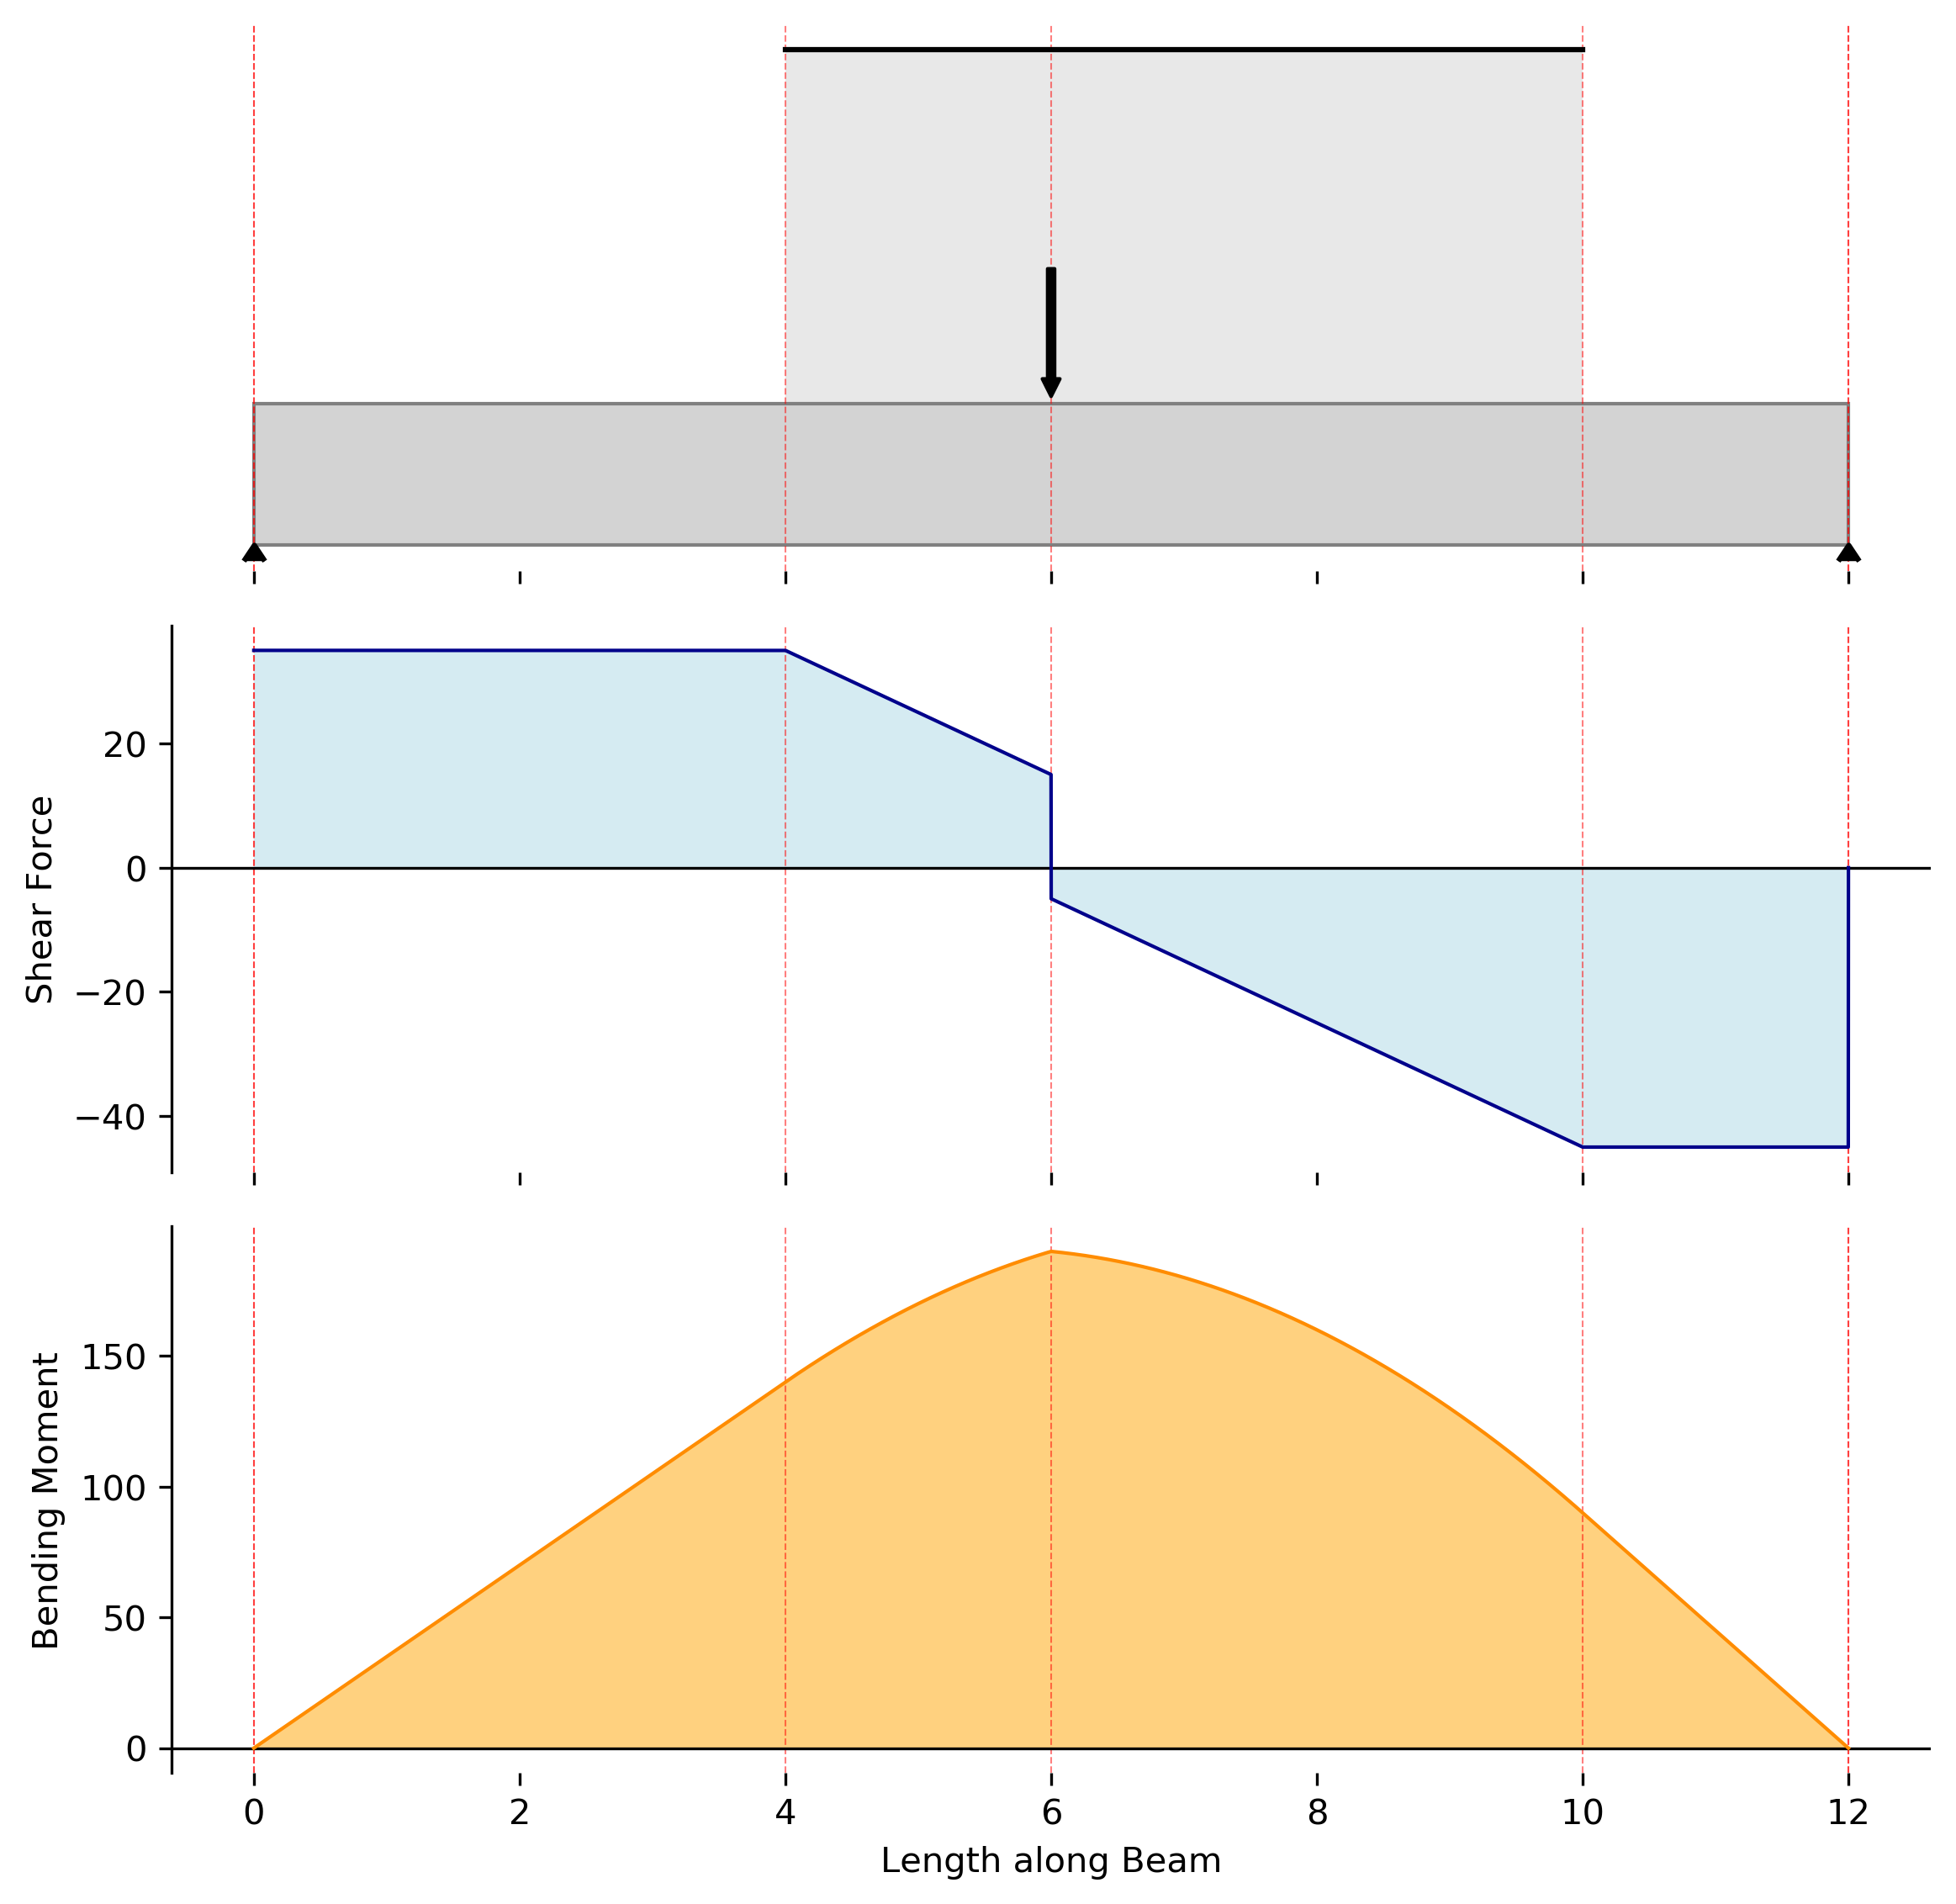

In [630]:
# Initialize a Beam object with length 12
beam = Beam(12)
# Specify the locations of the two supports (arbitrarily pinned or roller)
beam.first_support = 0
beam.second_support = 12
# Add list of external loads
external_loads = (PointLoad(-20, 6), # point load: 20 units of force downward, 6 units of length from left end
                  DistributedLoad(-10, (4,10)) # distributed load of magnitude 10 per unit length, direction downward, from position 4 to 10
                  )
beam.add_loads(external_loads)
# Output graphs and print important points
print('Reaction Force 1: ', beam._reaction_forces[0])
print('Reaction Force 2: ', beam._reaction_forces[1])
beam.draw_diagram()